In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ["http_proxy"] = "http://127.0.0.1:20171"
os.environ["https_proxy"] = "http://127.0.0.1:20171"

In [2]:
from embeddings_cpp import Tokenizer, Embedding, POOLING_METHOD_CLS, POOLING_METHOD_MEAN
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import numpy as np
import torch

def test_tokenizer_alignment(tokenizer_json, repo_name):

    tok_cpp = Tokenizer(tokenizer_json)
    auto_tok = AutoTokenizer.from_pretrained(repo_name)

    sentences = ["你好，今天天气怎么样？", "What's the weather like today?"]
    output_py = auto_tok(sentences, padding=True, truncation=True, return_tensors='pt')
    ouput_cpp = tok_cpp.encode_batch(sentences, True)

    
    auto_tok_output_input_ids = output_py["input_ids"]
    auto_tok_output_attention_mask = output_py["attention_mask"]
    for i in range(len(sentences)):
        print(f"text: {sentences[i]}")
        transformers_id = auto_tok_output_input_ids[i].numpy()
        transformers_attention_mask = auto_tok_output_attention_mask[i].numpy()


        embedings_cpp_id = np.array(ouput_cpp[i].ids)
        embedings_cpp_attention_mask = np.array(ouput_cpp[i].attention_mask)

        ids_mse = np.mean((transformers_id - embedings_cpp_id) ** 2)
        attetion_mask_mse = np.mean((transformers_attention_mask - embedings_cpp_attention_mask) ** 2)

        print(f"transformers ids: {transformers_id}")
        print(f"embeddings.cpp ids: {embedings_cpp_id}")
        print(f"ids mse: {ids_mse}")

        print(f"transformers attention mask: {transformers_attention_mask}")
        print(f"embeddings.cpp attention mask: {embedings_cpp_attention_mask}")
        print(f"attention mask mse: {attetion_mask_mse}")

def test_embedding_alignment(tokenizer_json, gguf_model, repo_name, pooling_method):
    def mean_pooling(hidden_state, mask):
        s = torch.sum(hidden_state * mask.unsqueeze(-1).float(), dim=1)
        d = mask.sum(axis=1, keepdim=True).float()
        return s / d
    def cls_pooling(hidden_state, mask):
        return hidden_state[:, 0]

    tok_py = AutoTokenizer.from_pretrained(repo_name)
    model_py = AutoModel.from_pretrained(repo_name)
    # print(type(tok_py))
    # print(type(model_py))

    model_sp = SentenceTransformer(repo_name)

    sentences = ["你好，今天天气怎么样？", "What's the weather like today?"]
    output_py = tok_py(sentences, padding=True, truncation=True, return_tensors='pt', max_length=8192)
    # print(f"output_py: {output_py}")
    res_py = model_py(**output_py, return_dict=True)
    # print(f"res_py: {res_py}")
    last_hidden_state = res_py.last_hidden_state
    # print(f"last_hidden_state: {last_hidden_state}")
    pooling_fn = cls_pooling if pooling_method == POOLING_METHOD_CLS else mean_pooling
    res_py = pooling_fn(last_hidden_state, output_py['attention_mask'])
    # print(f"pooling: {res_py}")
    res_py = torch.nn.functional.normalize(res_py, dim=-1)
    res_py = res_py.cpu().detach().numpy()

    model_cpp = Embedding(tokenizer_json, gguf_model)
    res_cpp = model_cpp.batch_encode(sentences, normalize=True, pooling_method=pooling_method)

    res_sp = model_sp.encode(sentences, normalize_embeddings=True)

    return res_py, res_cpp, res_sp

/home/yongsheng/miniconda3/envs/potasms/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jsons = ["../models/bge-m3.tokenizer.json", "../models/bge-base-zh-v1.5.tokenizer.json", "../models/text2vec-base-multilingual.tokenizer.json"]
ggufs = ["../models/bge-m3.fp32.gguf", "../models/bge-base-zh-v1.5.fp32.gguf", "../models/text2vec-base-multilingual.fp32.gguf"]
repos = ["BAAI/bge-m3", "BAAI/bge-base-zh-v1.5", "shibing624/text2vec-base-multilingual"]
pooling_methods = [POOLING_METHOD_CLS, POOLING_METHOD_CLS, POOLING_METHOD_MEAN]

In [4]:
results = []
for i in range(len(jsons)):
    print(f"===========testing: {repos[i]}===========")
    res_py, res_cpp, res_sp = test_embedding_alignment(jsons[i], ggufs[i], repos[i], pooling_methods[i])
    results.append((res_py, res_cpp, res_sp))

===========testing: BAAI/bge-m3===========



BertEncoder: GGUF
BertEncoder: model name:   BAAI/bge-m3
BertEncoder: architecture:   XLMRobertaModel
BertEncoder: description:  gguf model for embeddings.cpp
BertEncoder: GGUF version: 3
BertEncoder: alignment:    32
BertEncoder: n_tensors:    391
BertEncoder: n_kv:         12
BertEncoder: ftype:        f32

BertEncoder: MODEL
BertEncoder: n_vocab        = 250002
BertEncoder: n_max_tokens   = 8194
BertEncoder: n_embd         = 1024
BertEncoder: n_intermediate = 4096
BertEncoder: n_head         = 16
BertEncoder: n_layer        = 24
BertEncoder: layer_norm_eps = 1e-05

BertEncoder: using CPU backend
BertEncoder: tensor[0]: type = f32, n_dims = 2, name = embeddings.word_embeddings.weight, offset=0, type=0
BertEncoder: tensor[1]: type = f32, n_dims = 2, name = embeddings.position_embeddings.weight, offset=1024008192, type=0
BertEncoder: tensor[2]: type = f32, n_dims = 1, name = embeddings.token_type_embeddings.weight, offset=1057570816, type=0
BertEncoder: tensor[3]: type = f32, n_dims =

compute buffer size: 0.48 MB
===========testing: BAAI/bge-base-zh-v1.5===========



BertEncoder: GGUF
BertEncoder: model name:   BAAI/bge-base-zh-v1.5
BertEncoder: architecture:   BertModel
BertEncoder: description:  gguf model for embeddings.cpp
BertEncoder: GGUF version: 3
BertEncoder: alignment:    32
BertEncoder: n_tensors:    199
BertEncoder: n_kv:         12
BertEncoder: ftype:        f32

BertEncoder: MODEL
BertEncoder: n_vocab        = 21128
BertEncoder: n_max_tokens   = 512
BertEncoder: n_embd         = 768
BertEncoder: n_intermediate = 3072
BertEncoder: n_head         = 12
BertEncoder: n_layer        = 12
BertEncoder: layer_norm_eps = 1e-12

BertEncoder: using CPU backend
BertEncoder: tensor[0]: type = f32, n_dims = 2, name = embeddings.word_embeddings.weight, offset=0, type=0
BertEncoder: tensor[1]: type = f32, n_dims = 2, name = embeddings.position_embeddings.weight, offset=64905216, type=0
BertEncoder: tensor[2]: type = f32, n_dims = 2, name = embeddings.token_type_embeddings.weight, offset=66478080, type=0
BertEncoder: tensor[3]: type = f32, n_dims = 1,

compute buffer size: 0.47 MB
===========testing: shibing624/text2vec-base-multilingual===========



BertEncoder: GGUF
BertEncoder: model name:   shibing624/text2vec-base-multilingual
BertEncoder: architecture:   BertModel
BertEncoder: description:  gguf model for embeddings.cpp
BertEncoder: GGUF version: 3
BertEncoder: alignment:    32
BertEncoder: n_tensors:    199
BertEncoder: n_kv:         12
BertEncoder: ftype:        f32

BertEncoder: MODEL
BertEncoder: n_vocab        = 250037
BertEncoder: n_max_tokens   = 512
BertEncoder: n_embd         = 384
BertEncoder: n_intermediate = 1536
BertEncoder: n_head         = 12
BertEncoder: n_layer        = 12
BertEncoder: layer_norm_eps = 1e-12

BertEncoder: using CPU backend
BertEncoder: tensor[0]: type = f32, n_dims = 2, name = embeddings.word_embeddings.weight, offset=0, type=0
BertEncoder: tensor[1]: type = f32, n_dims = 2, name = embeddings.position_embeddings.weight, offset=384056832, type=0
BertEncoder: tensor[2]: type = f32, n_dims = 2, name = embeddings.token_type_embeddings.weight, offset=384843264, type=0
BertEncoder: tensor[3]: type

compute buffer size: 0.19 MB


                                       MSE (transformers)  \
BAAI/bge-m3                                  7.856230e-09   
BAAI/bge-base-zh-v1.5                        8.836764e-09   
shibing624/text2vec-base-multilingual        8.778699e-10   

                                       MSE (sentence_transformers)  
BAAI/bge-m3                                           7.851480e-09  
BAAI/bge-base-zh-v1.5                                 8.833642e-09  
shibing624/text2vec-base-multilingual                 8.776497e-10  


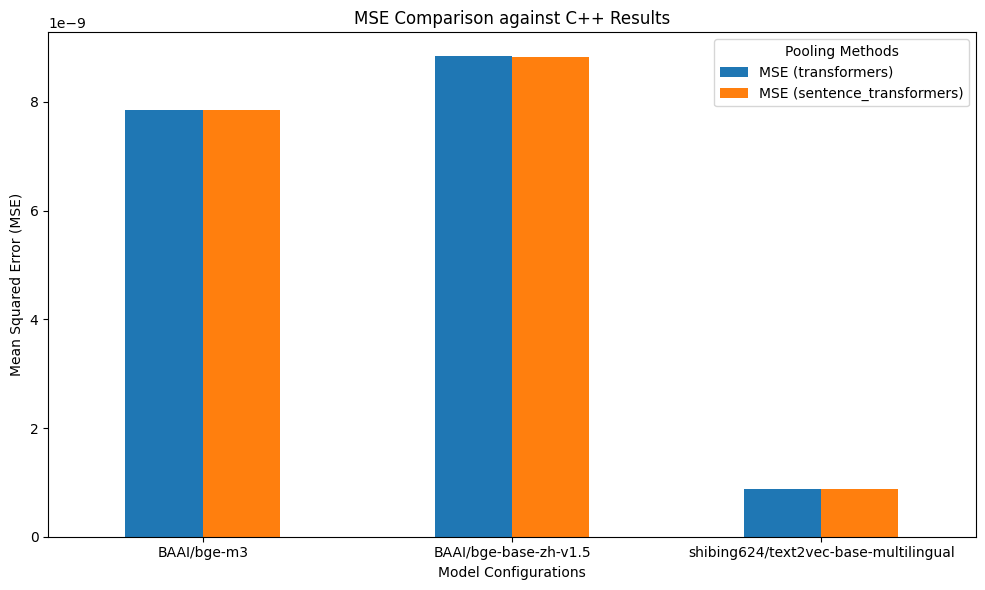

In [5]:
# cpp as baseline
mse_results = []
for res in results:
    res_py, res_cpp, res_sp = res
    mse_py = np.mean((res_py - res_cpp) ** 2)
    mse_sp = np.mean((res_sp - res_cpp) ** 2)
    mse_results.append((mse_py, mse_sp))

mse_df = pd.DataFrame(mse_results, columns=['MSE (transformers)', 'MSE (sentence_transformers)'], index=repos)

print(mse_df)

mse_df.plot(kind='bar', figsize=(10, 6))
plt.title('MSE Comparison against C++ Results')
plt.xlabel('Model Configurations')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title='Pooling Methods')
plt.show()